In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

import xgboost as xgb


In [2]:
# Preprocessing function
def preprocess_data(file_path):
    # Load the data
    df = pd.read_excel(file_path)
    
    # Ensure that 'Text' column is used as the independent variable
    df['Text'] = df['Text'].astype(str)
    
    # Drop any rows where 'Text' or 'Type' is NaN
    df.dropna(subset=['Text', 'Type'], inplace=True)
    
    # Define features and labels
    X = df['Text']
    y = df['Type']
    
    # Encode the labels into numeric values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Preprocess the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X)
    
    # Split the data into training and test sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test, label_encoder

# Load and preprocess data
file_path = 'test.xlsx'
X_train, X_test, y_train, y_test, label_encoder = preprocess_data(file_path)

In [3]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, label_encoder, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Results for SVM:
Training Accuracy: 0.9356
Test Accuracy: 0.6893
Classification Report:
              precision    recall  f1-score   support

      Answer       0.64      0.50      0.56       323
    Question       0.87      0.71      0.78       219
   Statement       0.66      0.80      0.72       504

    accuracy                           0.69      1046
   macro avg       0.72      0.67      0.69      1046
weighted avg       0.70      0.69      0.68      1046



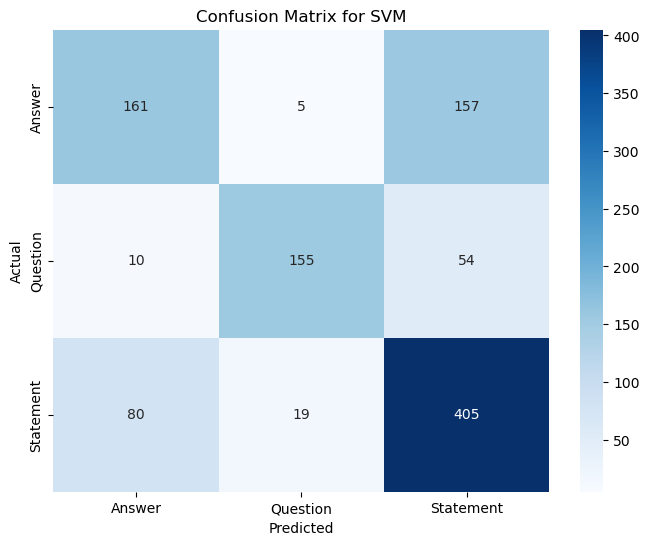

In [4]:
# Function to train and evaluate SVM
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    model = SVC()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for SVM:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Best Hyperparameters found by RandomizedSearchCV: {'kernel': 'linear', 'gamma': 'auto', 'degree': 4, 'coef0': 1, 'C': 0.46415888336127775}
Results for SVM after Randomized Hyperparameter Tuning:
Training Accuracy: 0.8233
Test Accuracy: 0.6750
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.60      0.51      0.55       323
    Question       0.85      0.70      0.77       219
   Statement       0.65      0.77      0.71       504

    accuracy                           0.67      1046
   macro avg       0.70      0.66      0.68      1046
weighted avg       0.68      0.67      0.67      1046

Confusion Matrix for Training Set:


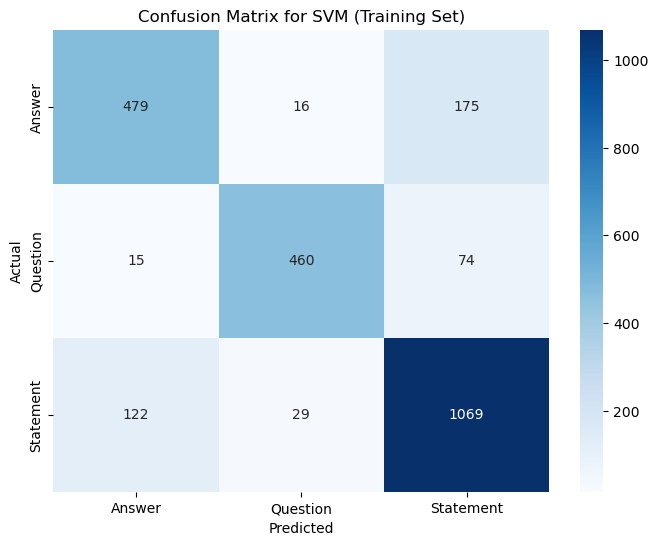

Confusion Matrix for Test Set:


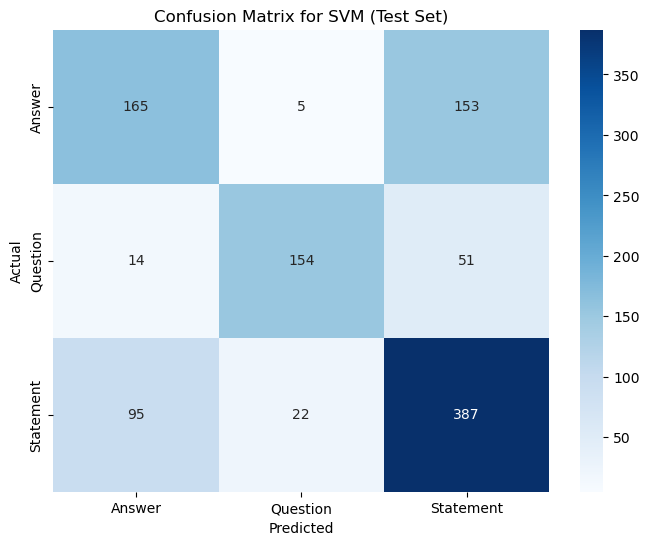

In [5]:


# Function to train and evaluate SVM with hyperparameter tuning (RandomizedSearchCV)
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    # Define hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'C': np.logspace(-3, 3, 10),        # C values on a log scale
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Adding specific gamma values to search
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'degree': [2, 3, 4],                # Only applicable for 'poly' kernel
        'coef0': [0, 0.1, 0.5, 1]           # Only applicable for 'poly' and 'sigmoid' kernels
    }

    # Initialize SVM and RandomizedSearchCV for hyperparameter tuning
    model = SVC()
    random_search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
    
    # Train the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = random_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by RandomizedSearchCV:", random_search.best_params_)
    print("Results for SVM after Randomized Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Best Hyperparameters found by GridSearchCV: {'C': 372.7593720314938, 'coef0': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
Results for SVM after GridSearch Hyperparameter Tuning:
Training Accuracy: 0.8553
Test Accuracy: 0.6797
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.60      0.53      0.56       323
    Question       0.84      0.74      0.79       219
   Statement       0.66      0.75      0.70       504

    accuracy                           0.68      1046
   macro avg       0.70      0.67      0.68      1046
weighted avg       0.68      0.68      0.68      1046

Confusion Matrix for Training Set:


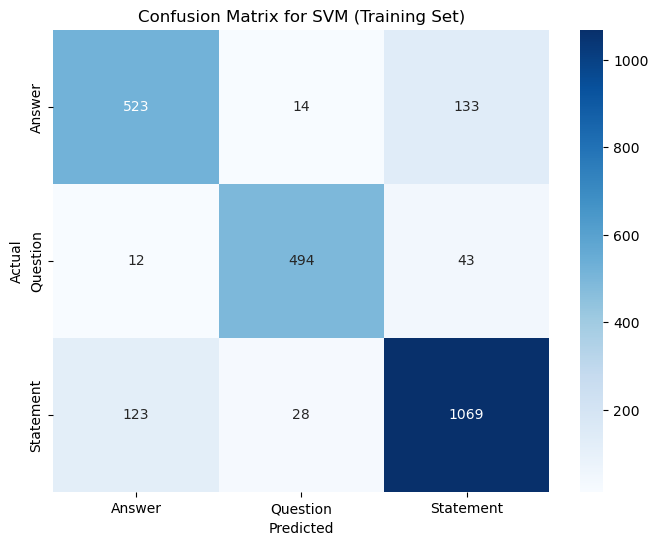

Confusion Matrix for Test Set:


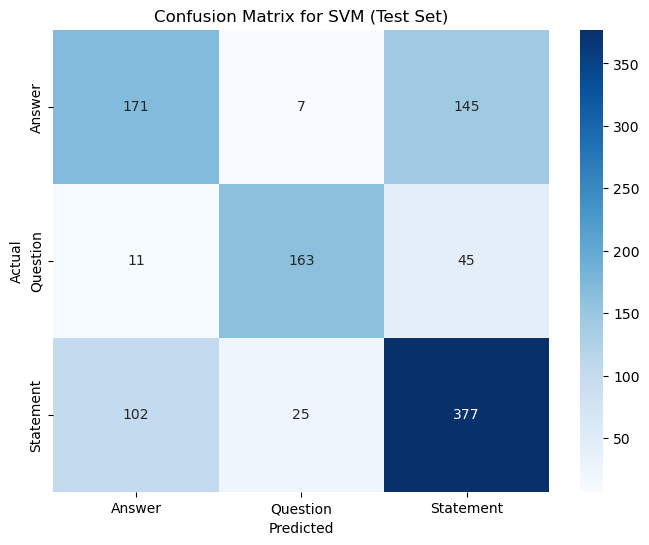

In [6]:


# Function to train and evaluate SVM with hyperparameter tuning (GridSearchCV)
def run_svm(X_train, X_test, y_train, y_test, label_encoder):
    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        'C': np.logspace(-3, 3, 15),        # C values on a log scale, fewer values compared to RandomSearchCV for fine-tuning
        'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001],  # Gamma values to search
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],   # Different SVM kernels
        'degree': [2, 3, 4],                # Only applicable for 'poly' kernel
        'coef0': [0, 0.1, 0.5, 1]           # Only applicable for 'poly' and 'sigmoid' kernels
    }

    # Initialize SVM and GridSearchCV for hyperparameter tuning
    model = SVC()
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
    # Train the model using GridSearchCV
    grid_search.fit(X_train, y_train)
    
    # Get the best model after tuning
    best_model = grid_search.best_estimator_
    
    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Best Hyperparameters found by GridSearchCV:", grid_search.best_params_)
    print("Results for SVM after GridSearch Hyperparameter Tuning:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep)
    
    # Plot confusion matrix for the training set
    print("Confusion Matrix for Training Set:")
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "SVM (Training Set)")
    
    # Plot confusion matrix for the test set
    print("Confusion Matrix for Test Set:")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "SVM (Test Set)")

# Call the updated function
run_svm(X_train, X_test, y_train, y_test, label_encoder)


Results for Decision Tree:
Training Accuracy: 0.9684
Test Accuracy: 0.6520
Classification Report:
              precision    recall  f1-score   support

      Answer       0.58      0.48      0.52       323
    Question       0.73      0.75      0.74       219
   Statement       0.66      0.72      0.69       504

    accuracy                           0.65      1046
   macro avg       0.65      0.65      0.65      1046
weighted avg       0.65      0.65      0.65      1046



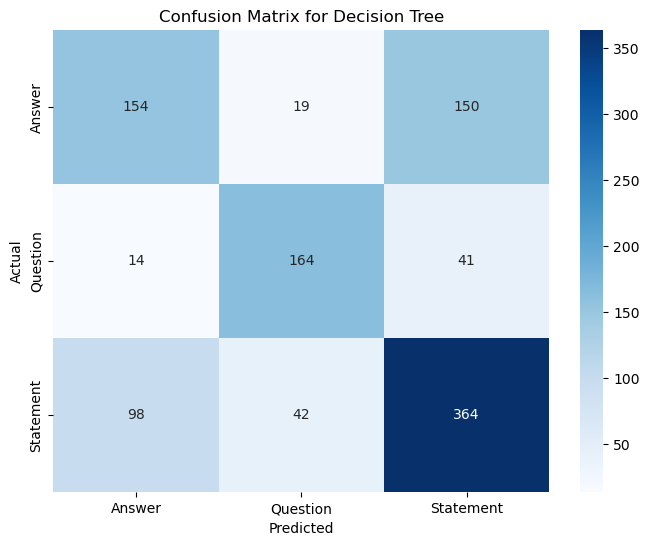

In [7]:
# Function to train and evaluate Decision Tree
def run_decision_tree(X_train, X_test, y_train, y_test, label_encoder):
    model = DecisionTreeClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Decision Tree:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree")

# Call the updated function
run_decision_tree(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'splitter': 'random', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Results for Decision Tree with RandomizedSearchCV:
Training Accuracy: 0.8151
Test Accuracy: 0.6482
Classification Report:
              precision    recall  f1-score   support

      Answer       0.57      0.41      0.47       323
    Question       0.77      0.71      0.74       219
   Statement       0.64      0.78      0.70       504

    accuracy                           0.65      1046
   macro avg       0.66      0.63      0.64      1046
weighted avg       0.64      0.65      0.64      1046



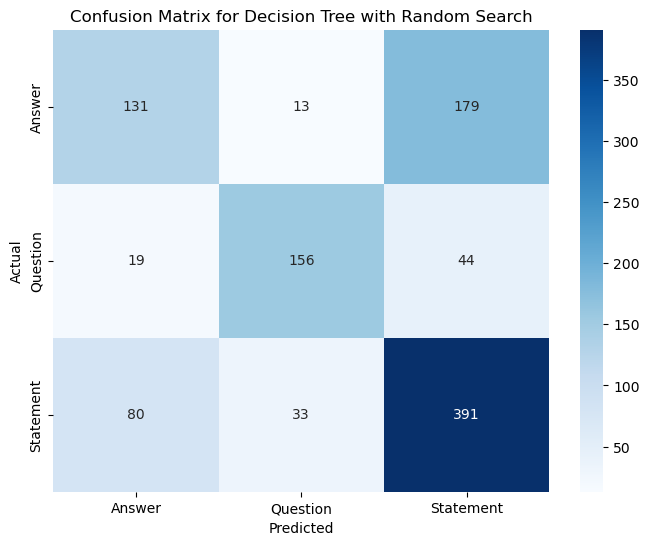

In [8]:
def run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Decision Tree model
    model = DecisionTreeClassifier()

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,  # number of iterations
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Decision Tree with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Decision Tree with Random Search")

# Call the updated function
run_decision_tree_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for Random Forest:
Training Accuracy: 0.9684
Test Accuracy: 0.6893
Classification Report:
              precision    recall  f1-score   support

      Answer       0.66      0.47      0.55       323
    Question       0.80      0.77      0.79       219
   Statement       0.66      0.80      0.72       504

    accuracy                           0.69      1046
   macro avg       0.71      0.68      0.69      1046
weighted avg       0.69      0.69      0.68      1046



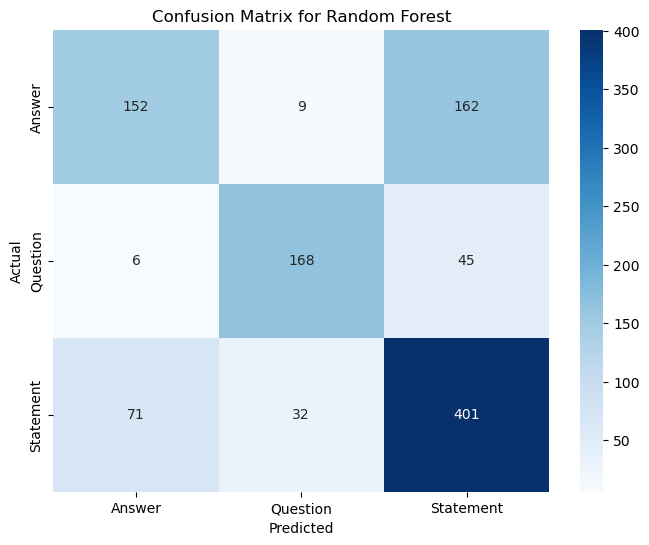

In [9]:
# Function to train and evaluate Random Forest
def run_random_forest(X_train, X_test, y_train, y_test, label_encoder):
    model = RandomForestClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print results
    print("Results for Random Forest:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest")

# Call the updated function
run_random_forest(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
Results for Random Forest with RandomizedSearchCV:
Training Accuracy: 0.9209
Test Accuracy: 0.7027
Classification Report:
              precision    recall  f1-score   support

      Answer       0.70      0.47      0.56       323
    Question       0.82      0.75      0.78       219
   Statement       0.66      0.83      0.74       504

    accuracy                           0.70      1046
   macro avg       0.73      0.68      0.70      1046
weighted avg       0.71      0.70      0.69      1046



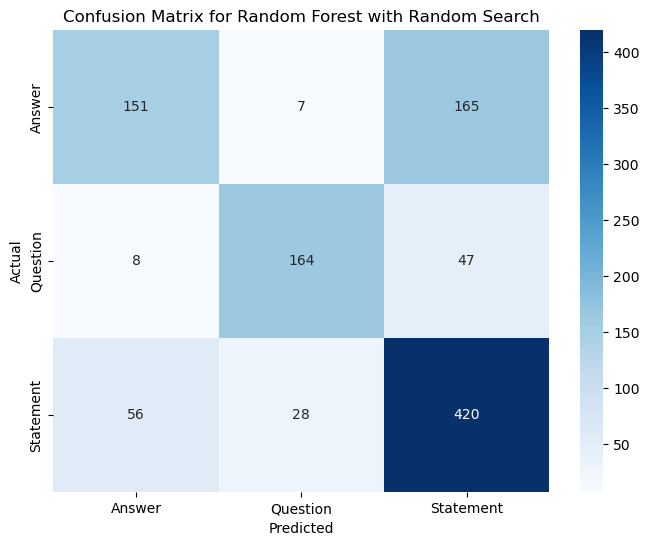

In [10]:
def run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Random Forest model
    model = RandomForestClassifier()

    # Corrected hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
        'max_features': ['sqrt', 'log2', None],     # Number of features to consider at every split
        'max_depth': [None, 10, 20, 30, 40],        # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
        'bootstrap': [True, False]                  # Whether bootstrap samples are used when building trees
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,  # number of iterations
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set (to calculate training accuracy)
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for the test set
    classification_rep = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Random Forest with RandomizedSearchCV:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_rep)
    
    # Plot confusion matrix (assuming plot_confusion_matrix is defined elsewhere)
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Random Forest with Random Search")

# Call the updated function
run_random_forest_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Results for AdaBoost (Training Set):
Training Accuracy: 0.7388
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.66      0.54      0.59       670
    Question       0.88      0.78      0.83       549
   Statement       0.72      0.83      0.77      1220

    accuracy                           0.74      2439
   macro avg       0.75      0.72      0.73      2439
weighted avg       0.74      0.74      0.74      2439


Results for AdaBoost (Test Set):
Test Accuracy: 0.6663
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.61      0.46      0.53       323
    Question       0.79      0.68      0.73       219
   Statement       0.65      0.79      0.71       504

    accuracy                           0.67      1046
   macro avg       0.68      0.64      0.66      1046
weighted avg       0.67      0.67      0.66      1046



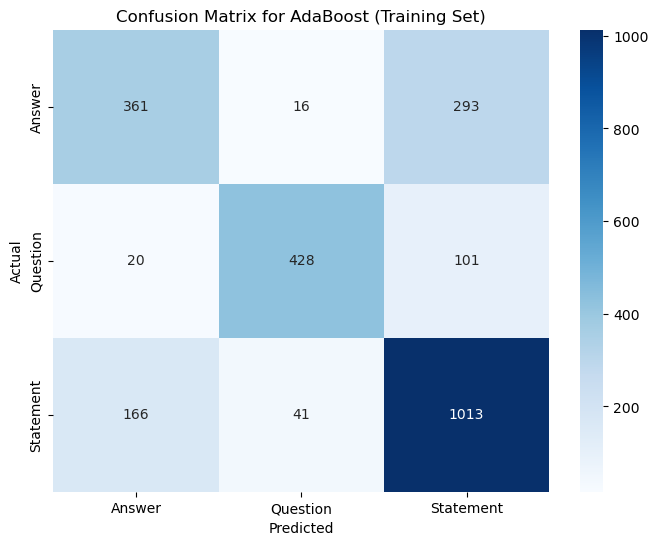

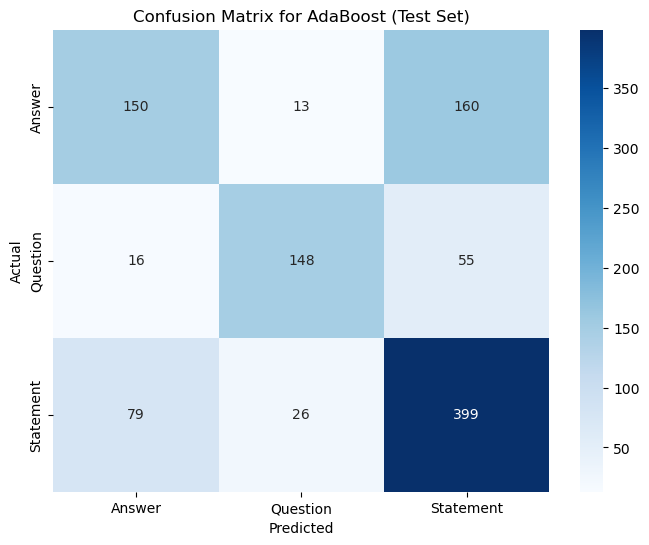

In [11]:
# Function to train and evaluate AdaBoost
def run_adaboost(X_train, X_test, y_train, y_test, label_encoder):
    model = AdaBoostClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for AdaBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for AdaBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "AdaBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "AdaBoost (Test Set)")

# Call the updated function
run_adaboost(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

Best Parameters: {'n_estimators': 300, 'learning_rate': 1.0, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 7}
Results for AdaBoost with RandomizedSearchCV (Training Set):
Training Accuracy: 0.9528
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.90      0.94      0.92       670
    Question       1.00      1.00      1.00       549
   Statement       0.96      0.94      0.95      1220

    accuracy                           0.95      2439
   macro avg       0.95      0.96      0.96      2439
weighted avg       0.95      0.95      0.95      2439


Results for AdaBoost with RandomizedSearchCV (Test Set):
Test Accuracy: 0.6644
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.57      0.56      0.57       323
    Question       0.77      0.75      0.76       219
   Statement       0.68      0.69      0.68       504

    a

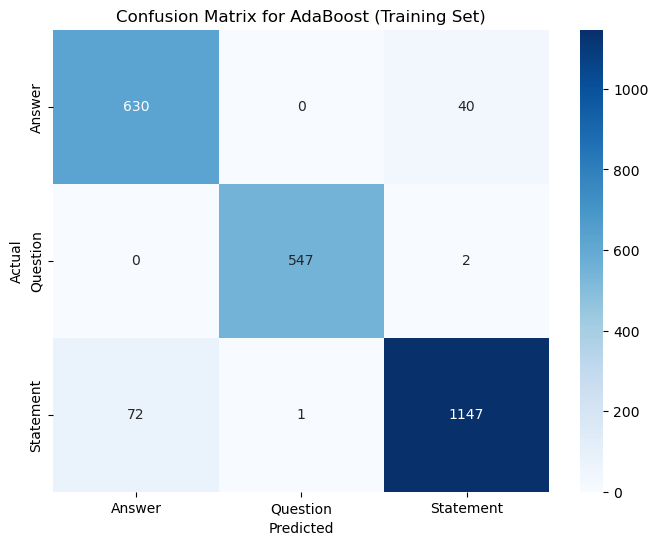

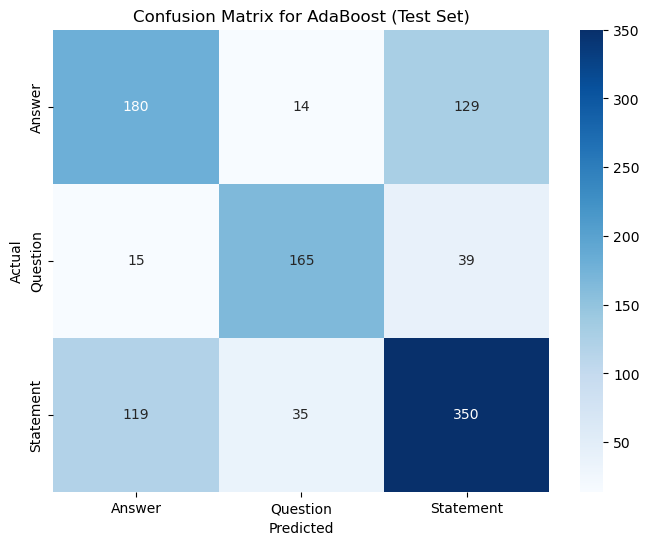

In [12]:
def run_adaboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # AdaBoost model
    model = AdaBoostClassifier(estimator=DecisionTreeClassifier())

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100, 200, 300, 500],              # Number of boosting rounds
        'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],     # Learning rate
        'estimator__max_depth': [1, 2, 3, 4, 5, 6, 7],         # Depth of the base estimator
        'estimator__min_samples_split': [2, 5, 10],            # Minimum samples to split an internal node
        'estimator__min_samples_leaf': [1, 2, 4],              # Minimum samples required at a leaf node
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,  # number of iterations
        cv=5,       # cross-validation
        verbose=1,  # display progress
        n_jobs=-1,  # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for AdaBoost with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for AdaBoost with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "AdaBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "AdaBoost (Test Set)")

# Call the updated function
run_adaboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for Naive Bayes (Training Set):
Training Accuracy: 0.8274
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.89      0.64      0.74       670
    Question       0.92      0.79      0.85       549
   Statement       0.78      0.95      0.85      1220

    accuracy                           0.83      2439
   macro avg       0.86      0.79      0.82      2439
weighted avg       0.84      0.83      0.82      2439


Results for Naive Bayes (Test Set):
Test Accuracy: 0.6453
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.67      0.34      0.45       323
    Question       0.81      0.59      0.68       219
   Statement       0.60      0.86      0.71       504

    accuracy                           0.65      1046
   macro avg       0.69      0.60      0.62      1046
weighted avg       0.67      0.65      0.62      1046



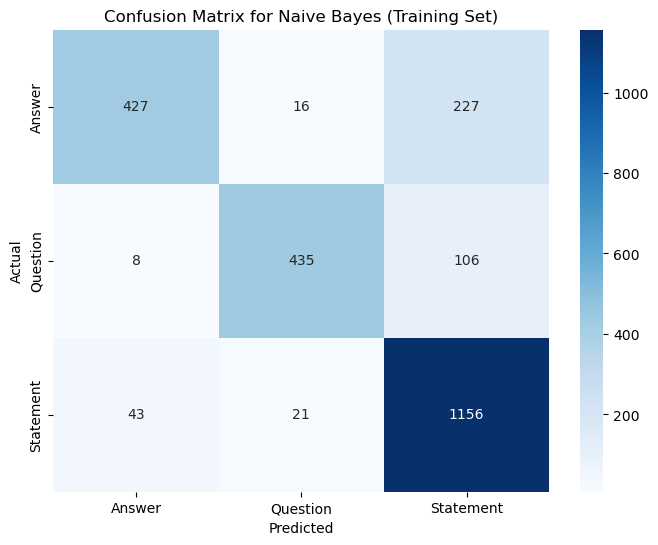

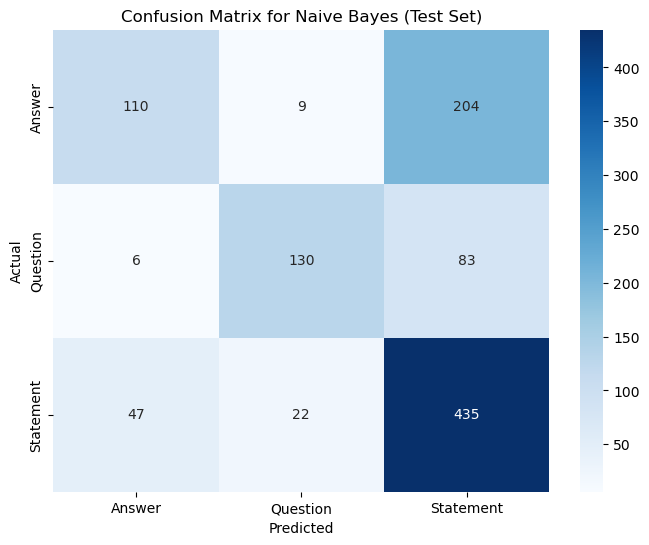

In [13]:
# Function to train and evaluate Naive Bayes
def run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder):
    model = MultinomialNB()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for Naive Bayes (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for Naive Bayes (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "Naive Bayes (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Naive Bayes (Test Set)")

# Call the updated function
run_naive_bayes(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'fit_prior': True, 'alpha': 0.5}
Results for Naive Bayes with RandomizedSearchCV (Training Set):
Training Accuracy: 0.8532
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.85      0.76      0.80       670
    Question       0.91      0.85      0.88       549
   Statement       0.83      0.91      0.87      1220

    accuracy                           0.85      2439
   macro avg       0.86      0.84      0.85      2439
weighted avg       0.85      0.85      0.85      2439


Results for Naive Bayes with RandomizedSearchCV (Test Set):
Test Accuracy: 0.6702
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.66      0.50      0.57       323
    Question       0.75      0.65      0.70       219
   Statement       0.65      0.78      0.71       504

    accuracy                           0.67 

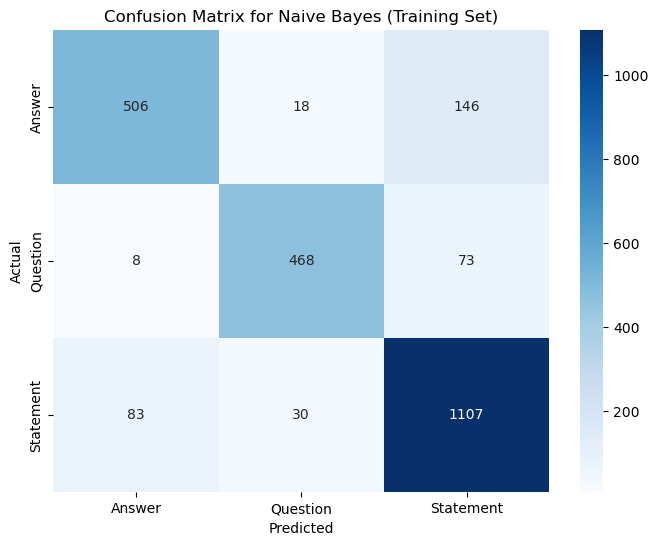

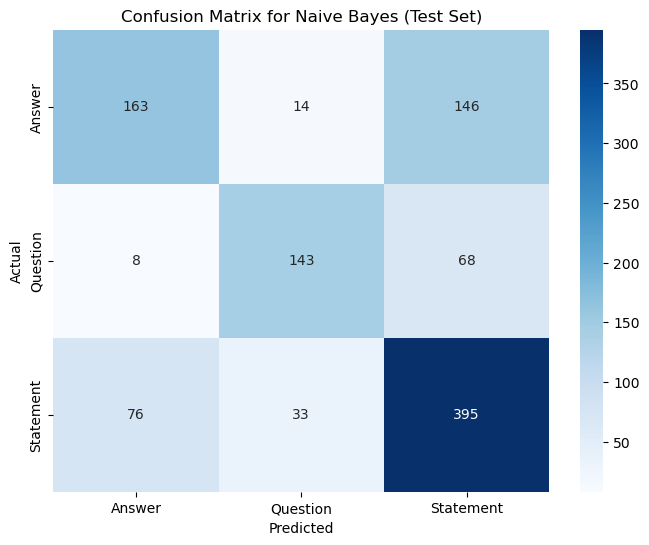

In [14]:

def run_naive_bayes_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # Naive Bayes model
    model = MultinomialNB()

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
        'fit_prior': [True, False],          # Whether to learn class priors or not
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=10,   # number of iterations
        cv=5,        # cross-validation
        verbose=1,   # display progress
        n_jobs=-1,   # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for Naive Bayes with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for Naive Bayes with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "Naive Bayes (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Naive Bayes (Test Set)")

# Call the updated function
run_naive_bayes_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for XGBoost (Training Set):
Training Accuracy: 0.9311
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.95      0.82      0.88       670
    Question       0.99      0.96      0.98       549
   Statement       0.90      0.98      0.94      1220

    accuracy                           0.93      2439
   macro avg       0.95      0.92      0.93      2439
weighted avg       0.93      0.93      0.93      2439


Results for XGBoost (Test Set):
Test Accuracy: 0.7084
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.64      0.55      0.59       323
    Question       0.83      0.79      0.81       219
   Statement       0.70      0.77      0.73       504

    accuracy                           0.71      1046
   macro avg       0.72      0.70      0.71      1046
weighted avg       0.71      0.71      0.71      1046



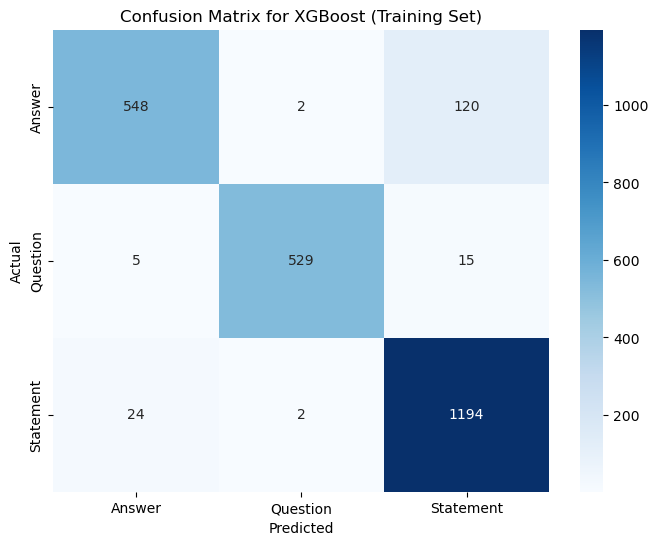

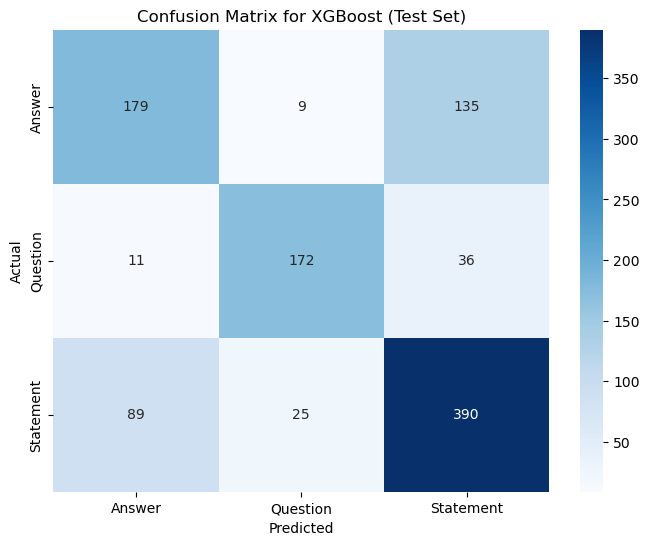

In [15]:
# Function to train and evaluate XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, label_encoder):
    model = xgb.XGBClassifier(eval_metric='mlogloss')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for XGBoost (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost(X_train, X_test, y_train, y_test, label_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Results for XGBoost with RandomizedSearchCV (Training Set):
Training Accuracy: 0.9131
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.93      0.79      0.85       670
    Question       0.98      0.96      0.97       549
   Statement       0.88      0.96      0.92      1220

    accuracy                           0.91      2439
   macro avg       0.93      0.90      0.91      2439
weighted avg       0.92      0.91      0.91      2439


Results for XGBoost with RandomizedSearchCV (Test Set):
Test Accuracy: 0.7103
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.66      0.54      0.59       323
    Question       0.83      0.78      

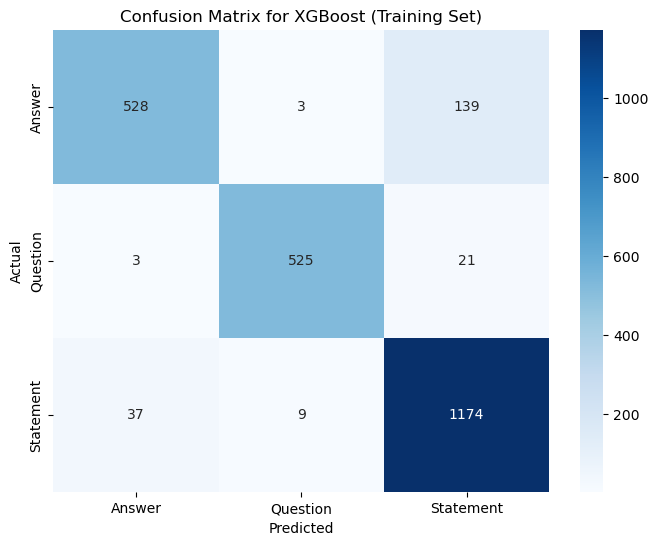

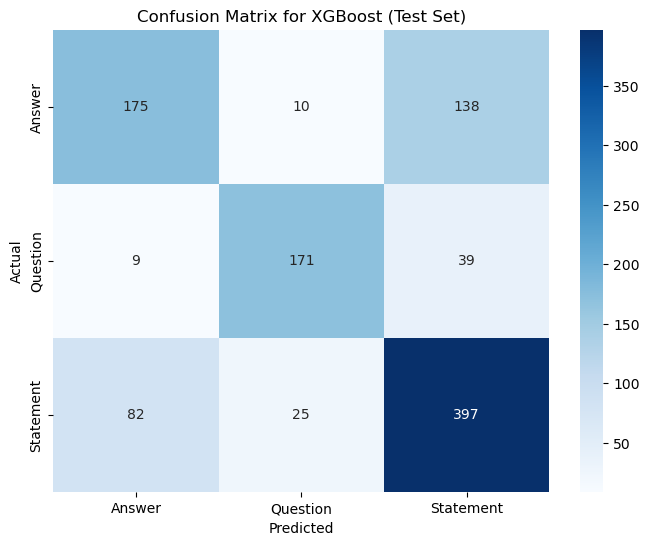

In [16]:

def run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    # XGBoost model without use_label_encoder
    model = xgb.XGBClassifier(eval_metric='mlogloss')

    # Hyperparameter space for RandomizedSearchCV
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],    # Number of trees
        'learning_rate': [0.01, 0.05, 0.1, 0.2],     # Step size shrinkage
        'max_depth': [3, 4, 5, 6, 7],                # Maximum depth of a tree
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],     # Subsample ratio of the training instance
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],           # Minimum loss reduction required to make a further partition on a leaf node
        'reg_alpha': [0, 0.01, 0.1, 1.0],           # L1 regularization term on weights
        'reg_lambda': [0.01, 0.1, 1.0]              # L2 regularization term on weights
    }

    # RandomizedSearchCV setup
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50,   # number of iterations
        cv=5,        # cross-validation
        verbose=1,   # display progress
        n_jobs=-1,   # use all processors
        random_state=42
    )

    # Train the model with random search
    random_search.fit(X_train, y_train)

    # Best parameters and best estimator
    print(f"Best Parameters: {random_search.best_params_}")

    # Predictions on the test set
    y_pred_test = random_search.predict(X_test)
    test_accuracy = random_search.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = random_search.predict(X_train)
    train_accuracy = random_search.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for XGBoost with RandomizedSearchCV (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for XGBoost with RandomizedSearchCV (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "XGBoost (Training Set)")
    
    # Plot confusion matrix for test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "XGBoost (Test Set)")

# Call the updated function
run_xgboost_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for KNN (Training Set):
Training Accuracy: 0.6831
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.64      0.39      0.48       670
    Question       0.84      0.48      0.61       549
   Statement       0.66      0.94      0.78      1220

    accuracy                           0.68      2439
   macro avg       0.72      0.60      0.62      2439
weighted avg       0.70      0.68      0.66      2439


Results for KNN (Test Set):
Test Accuracy: 0.5535
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.46      0.15      0.22       323
    Question       0.79      0.38      0.52       219
   Statement       0.54      0.89      0.67       504

    accuracy                           0.55      1046
   macro avg       0.59      0.47      0.47      1046
weighted avg       0.56      0.55      0.50      1046



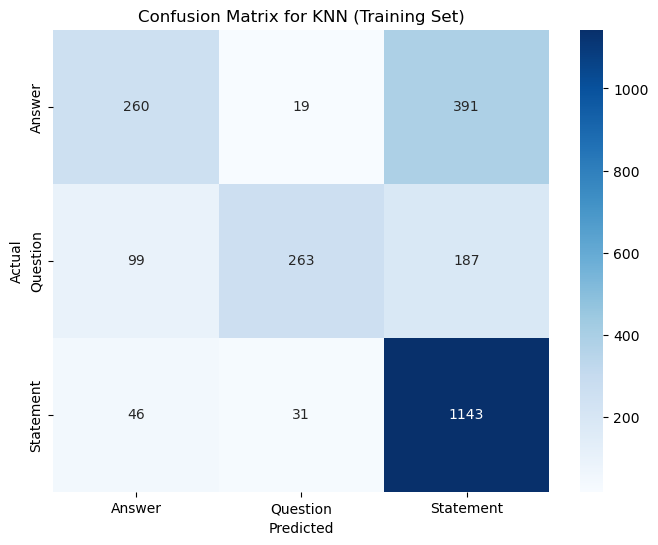

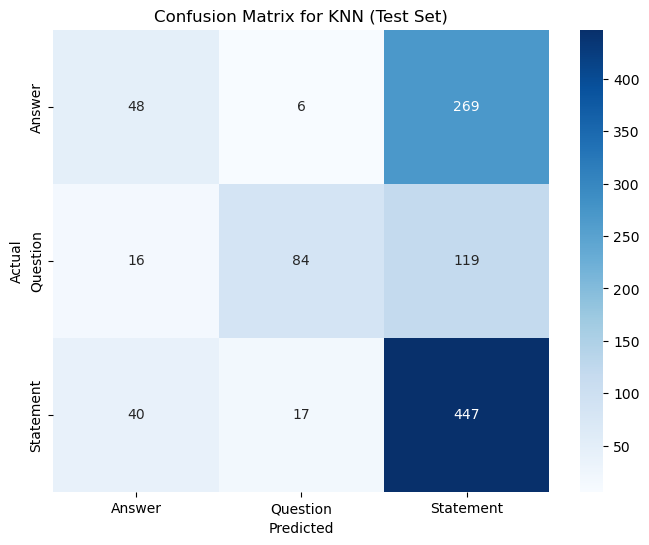

In [17]:
# Function to train and evaluate KNN
def run_knn(X_train, X_test, y_train, y_test, label_encoder):
    model = KNeighborsClassifier()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)
    
    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)
    
    # Print training results
    print("Results for KNN (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)
    
    # Print test results
    print("\nResults for KNN (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)
    
    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "KNN (Training Set)")
    
    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "KNN (Test Set)")

# Call the updated function
run_knn(X_train, X_test, y_train, y_test, label_encoder)

Best Parameters: {'weights': 'distance', 'n_neighbors': 26, 'metric': 'euclidean'}
Results for KNN with Random Search (Training Set):
Training Accuracy: 0.9680
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.93      0.96      0.94       670
    Question       1.00      1.00      1.00       549
   Statement       0.98      0.96      0.97      1220

    accuracy                           0.97      2439
   macro avg       0.97      0.97      0.97      2439
weighted avg       0.97      0.97      0.97      2439


Results for KNN with Random Search (Test Set):
Test Accuracy: 0.6128
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.61      0.24      0.35       323
    Question       0.81      0.54      0.65       219
   Statement       0.58      0.88      0.70       504

    accuracy                           0.61      1046
   macro avg       0.67      0.56      0.57  

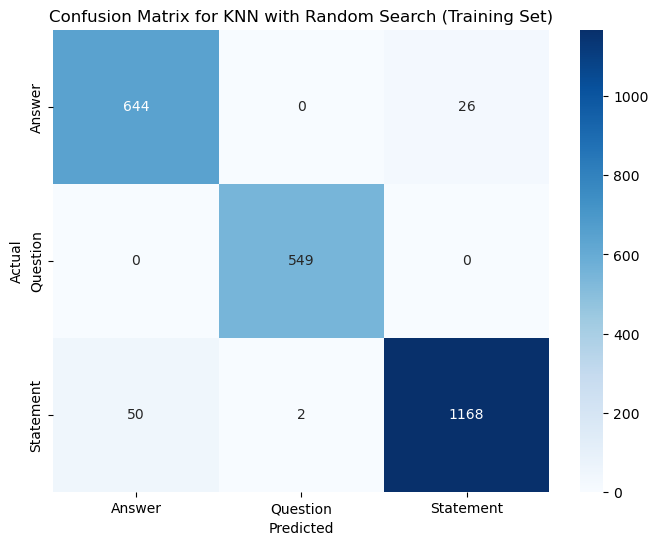

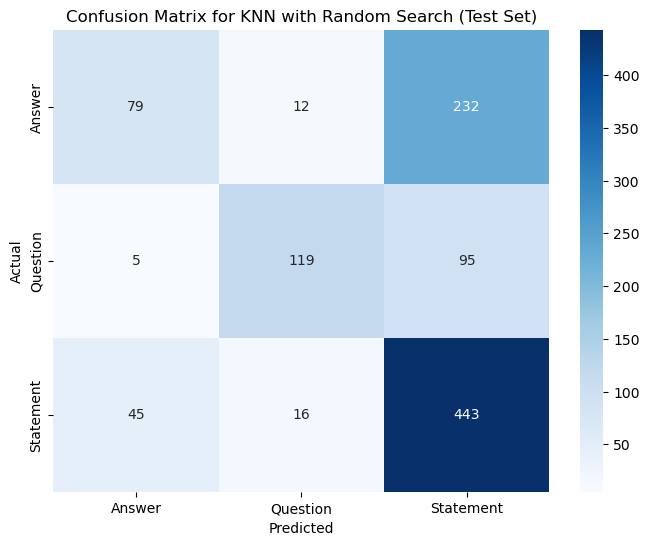

In [18]:
def run_knn_with_random_search(X_train, X_test, y_train, y_test, label_encoder):
    model = KNeighborsClassifier()

    # Define hyperparameter space for random search
    param_distributions = {
        'n_neighbors': np.arange(1, 31),  # Search for optimal number of neighbors between 1 and 30
        'weights': ['uniform', 'distance'],  # Uniform or distance-based weighting
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
    }

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Best parameters found
    print("Best Parameters:", random_search.best_params_)

    # Evaluate the best model
    best_model = random_search.best_estimator_

    # Predictions on the test set
    y_pred_test = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)

    # Predictions on the training set
    y_pred_train = best_model.predict(X_train)
    train_accuracy = best_model.score(X_train, y_train)

    # Generate classification report for both training and test sets
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print training results
    print("Results for KNN with Random Search (Training Set):")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)

    # Print test results
    print("\nResults for KNN with Random Search (Test Set):")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrix for the training set
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "KNN with Random Search (Training Set)")

    # Plot confusion matrix for the test set
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "KNN with Random Search (Test Set)")

# Call the updated function
run_knn_with_random_search(X_train, X_test, y_train, y_test, label_encoder)

Results for Best Model:
Training Accuracy: 0.9676
Classification Report (Training Set):
              precision    recall  f1-score   support

      Answer       0.93      0.96      0.94       670
    Question       1.00      1.00      1.00       549
   Statement       0.98      0.96      0.97      1220

    accuracy                           0.97      2439
   macro avg       0.97      0.97      0.97      2439
weighted avg       0.97      0.97      0.97      2439

Test Accuracy: 0.6501
Classification Report (Test Set):
              precision    recall  f1-score   support

      Answer       0.58      0.50      0.54       323
    Question       0.72      0.72      0.72       219
   Statement       0.66      0.72      0.69       504

    accuracy                           0.65      1046
   macro avg       0.65      0.64      0.65      1046
weighted avg       0.65      0.65      0.65      1046



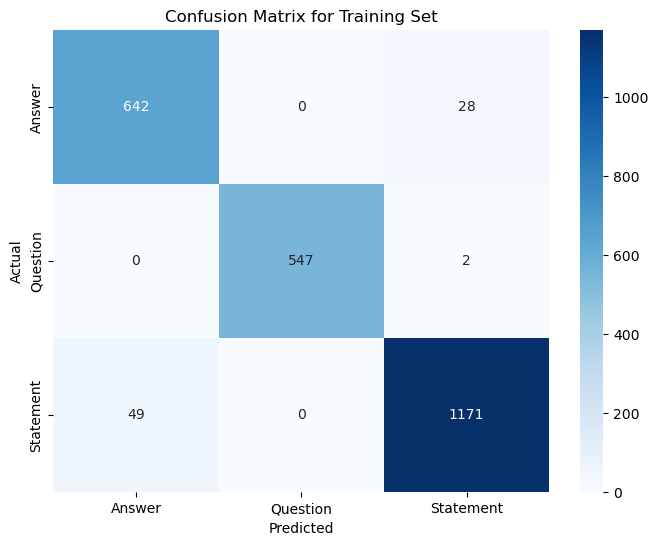

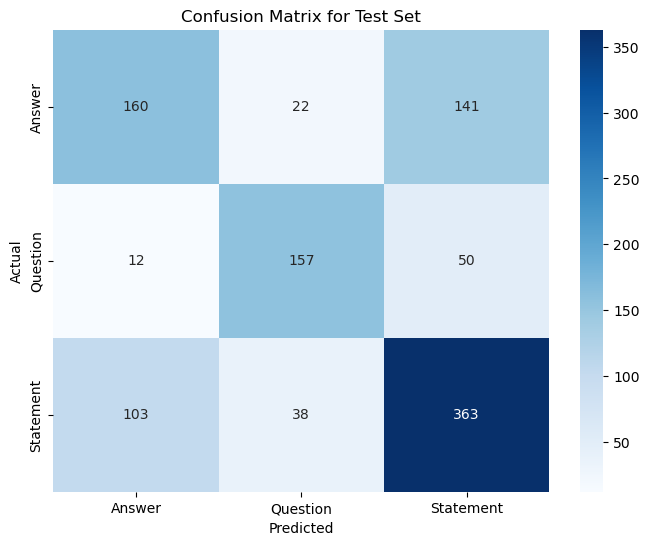

In [19]:
# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder):
    # Predictions on the training set
    y_pred_train = model.predict(X_train)
    train_accuracy = model.score(X_train, y_train)

    # Predictions on the test set
    y_pred_test = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)

    # Generate classification reports
    classification_rep_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
    classification_rep_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

    # Print results
    print("Results for Best Model:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print("Classification Report (Training Set):")
    print(classification_rep_train)

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("Classification Report (Test Set):")
    print(classification_rep_test)

    # Plot confusion matrices
    plot_confusion_matrix(y_train, y_pred_train, label_encoder, "Training Set")
    plot_confusion_matrix(y_test, y_pred_test, label_encoder, "Test Set")
# Train the MLP Classifier (or use any other model)
model = MLPClassifier(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
evaluate_model(model, X_train, y_train, X_test, y_test, label_encoder)
